# PoseNet for Self-Localization on Apolloscape Dataset

In [9]:
%load_ext autoreload
%autoreload 2

from IPython.display import HTML
from IPython.display import clear_output

import numpy as np

import torch
from torch import nn
from torchvision import transforms, models
import torchvision.utils as vutils
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
from torchviz import make_dot

from datasets.apolloscape import Apolloscape

from utils.common import draw_poses
from utils.common import draw_record
from utils.common import imshow
from utils.common import save_checkpoint
from utils.common import AverageMeter
from utils.common import calc_poses_params

from models.posenet import PoseNet, PoseNetCriterion

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

from PIL import Image

from tqdm import tqdm
import os
import time
from datetime import datetime

%matplotlib inline
plt.ion()


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Load Apolloscape Dataset

In [32]:
APOLLO_PATH = "./data/apolloscape"

normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225])

# Resize data before using
transform = transforms.Compose([
    transforms.Resize(260),
    transforms.CenterCrop(250),
    transforms.ToTensor(),
    normalize
])


train_record = 'Record001'
train_dataset = Apolloscape(root=os.path.join(APOLLO_PATH), road="zpark-sample",
                             transform=transform, record=train_record, normalize_poses=True,
                             pose_format='quat', train=True, cache_transform=True)

val_record = 'Record011'
val_dataset = Apolloscape(root=os.path.join(APOLLO_PATH), road="zpark-sample",
                             transform=transform, record=val_record, normalize_poses=True,
                             pose_format='quat', train=False, cache_transform=True)

test_record = 'Record013'
test_dataset = Apolloscape(root=os.path.join(APOLLO_PATH), road="zpark-sample",
                             transform=transform, record=test_record, normalize_poses=True,
                             pose_format='quat', train=False, cache_transform=True)



print(train_dataset)
print(val_dataset)
print(test_dataset)

train_dataloader = DataLoader(train_dataset, batch_size=8) # batch_size = 75
val_dataloader = DataLoader(val_dataset, batch_size=8) # batch_size = 75
test_dataloader = DataLoader(test_dataset, batch_size=8) # batch_size = 75


Dataset: Apolloscape
    Road: zpark-sample
    Record: Record001
    Train: True
    Normalize Poses: True
    Length: 121 of 1121
    Cameras: ['Camera_2', 'Camera_1']
    Records: ['Record001', 'Record002', 'Record003', 'Record004', 'Record006', 'Record007', 'Record008', 'Record009', 'Record010', 'Record011', 'Record012', 'Record013', 'Record014']

Dataset: Apolloscape
    Road: zpark-sample
    Record: Record011
    Train: False
    Normalize Poses: True
    Length: 87 of 378
    Cameras: ['Camera_2', 'Camera_1']
    Records: ['Record001', 'Record002', 'Record003', 'Record004', 'Record006', 'Record007', 'Record008', 'Record009', 'Record010', 'Record011', 'Record012', 'Record013', 'Record014']

Dataset: Apolloscape
    Road: zpark-sample
    Record: Record013
    Train: False
    Normalize Poses: True
    Length: 120 of 378
    Cameras: ['Camera_2', 'Camera_1']
    Records: ['Record001', 'Record002', 'Record003', 'Record004', 'Record006', 'Record007', 'Record008', 'Record009', 'Reco

## Draw Train and Val datasets

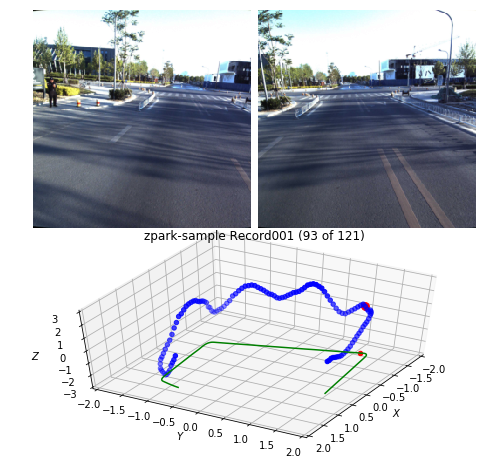

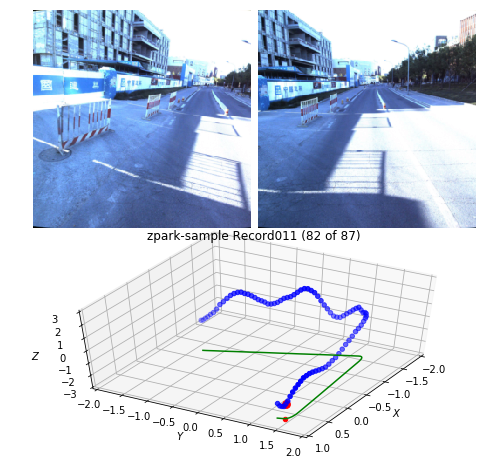

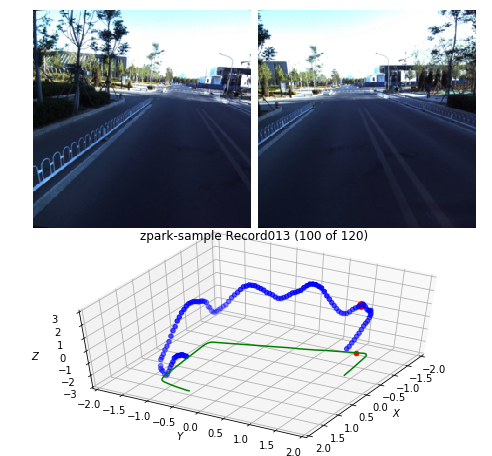

In [36]:
# Draw datasets
draw_record(train_dataset)
plt.show()

draw_record(val_dataset)
plt.show()

draw_record(test_dataset)
plt.show()

## Device set up

In [4]:
device = None
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
print('device = {}'.format(device))

device = cuda


## Train and Validate Functions

In [45]:
# train function
def train(train_loader, model, criterion, optimizer, epoch, max_epoch, log_freq=1, print_sum=True):
    
    # switch model to training
    model.train()
    
#     log_freq = 0
    
    losses = AverageMeter()
    
    end = time.time()
    for idx, (batch_images, batch_poses) in enumerate(train_loader):
#         if idx < len(train_loader) - 1: continue
        data_time = (time.time() - end)
        
        batch_images = [x.to(device) for x in batch_images]
        batch_poses = [x.to(device) for x in batch_poses]
        
        out = model(batch_images)
        loss = criterion(out, batch_poses)
#         print('loss = {}'.format(loss))

        
        losses.update(loss, len(batch_images) * batch_images[0].size(0))
        
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        batch_time = (time.time() - end)
        end = time.time()
        
        if log_freq != 0 and idx % log_freq == 0:
            print('Epoch: [{}/{}]\tBatch: [{}/{}]\t'
                  'Time: {batch_time:.3f}\t'
                  'Data Time: {data_time:.3f}\t'
                  'Loss: {losses.val:.3f}\t'
                  'Avg Loss: {losses.avg:.3f}\t'.format(
                   epoch, max_epoch - 1, idx, len(train_loader) - 1,
                   batch_time=batch_time, data_time=data_time, losses=losses))
            
    if print_sum:
        print('Epoch: [{}/{}]\tTraining Loss: {:.3f}'.format(epoch, max_epoch - 1, losses.avg))
        
    return losses.avg
    
    
def validate(val_loader, model, criterion, epoch, log_freq=1, print_sum=True):
    
#     log_freq = 0 # len(val_loader)
    
    losses = AverageMeter()
    
    # set model to evaluation
    model.eval()
    
    with torch.no_grad():
        end = time.time()
        for idx, (batch_images, batch_poses) in enumerate(val_loader):
            data_time = time.time() - end
            batch_images = [x.to(device) for x in batch_images]
            batch_poses = [x.to(device) for x in batch_poses]
            
            # compute model output
            out = model(batch_images)
            loss = criterion(out, batch_poses)
            
            losses.update(loss, len(batch_images) * batch_images[0].size(0))
            
            batch_time = time.time() - end
            end = time.time()
            
            if log_freq != 0 and idx % log_freq == 0:
                print('Val Epoch: {}\t'
                      'Time: {batch_time:.3f}\t'
                      'Data Time: {data_time:.3f}\t'
                      'Loss: {losses.val:.3f}\t'
                      'Avg Loss: {losses.avg:.3f}'.format(
                       epoch, batch_time=batch_time, data_time=data_time, losses=losses))
                
    
    if print_sum:
        print('Epoch: [{}]\tValidation Loss: {:.3f}'.format(epoch, losses.avg))
        
    return losses.avg


## Create Model, Criterion and Optimizer

In [65]:
# Create pretrained feature extractor
feature_extractor = models.resnet18(pretrained=True)

# Create model
model = PoseNet(feature_extractor)
model = model.to(device)

# Criterion
criterion = PoseNetCriterion()

# Create optimizer
optimizer = optim.Adam(model.parameters(), lr=5e-6, weight_decay=0.0005)

start_epoch = 0


## Restore from Chekpoint

In [66]:
# Restore from checkpoint
checkpoint_file = '_checkpoints/20180802_152934_apollo_zpark_r001_v2_e1000.pth.tar'

if 'checkpoint_file' in locals() and checkpoint_file is not None:
    if os.path.isfile(checkpoint_file):
        print('Loading from checkpoint: {}'.format(checkpoint_file))
        checkpoint = torch.load(checkpoint_file)
        model.load_state_dict(checkpoint['model_state_dict'])
        optimizer.load_state_dict(checkpoint['optim_state_dict'])
        start_epoch = checkpoint['epoch']


Loading from checkpoint: _checkpoints/20180802_152934_apollo_zpark_r001_v2_e1000.pth.tar


## Run Training

In [69]:
if 'start_epoch' not in locals():
    start_epoch = 0
    
# train_dataloader = DataLoader(train_dataset, batch_size=8) # batch_size = 75
# optimizer = optim.Adam(model.parameters(), lr=1e-6, weight_decay=0.0005)

n_epochs = start_epoch + 2000
print('Training ...')
val_freq = 5
for e in range(start_epoch, n_epochs):

    end = time.time()
    train(train_dataloader, model, criterion, optimizer, e, n_epochs, log_freq=0)
#     print('Train epoch time: {:.3f}'.format(time.time() - end))
    
#     print('Validation ...')
    if e & val_freq == 0:
        end = time.time()
        validate(val_dataloader, model, criterion, e, log_freq=0)
#     print('Validation epoch time: {:.3f}'.format(time.time() - end))

#     print('Test dataset ...')
#     validate(test_dataloader, model, criterion, e, log_freq=0)

start_epoch = n_epochs

print('n_epochs = {}'.format(n_epochs))


Training ...
Epoch: [1400/3399]	Training Loss: 0.183
Epoch: [1400]	Validation Loss: 1.038
Epoch: [1401/3399]	Training Loss: 0.189
Epoch: [1402/3399]	Training Loss: 0.134
Epoch: [1402]	Validation Loss: 1.063
Epoch: [1403/3399]	Training Loss: 0.163
Epoch: [1404/3399]	Training Loss: 0.175
Epoch: [1405/3399]	Training Loss: 0.157
Epoch: [1406/3399]	Training Loss: 0.174
Epoch: [1407/3399]	Training Loss: 0.147
Epoch: [1408/3399]	Training Loss: 0.163
Epoch: [1408]	Validation Loss: 1.060
Epoch: [1409/3399]	Training Loss: 0.195
Epoch: [1410/3399]	Training Loss: 0.141
Epoch: [1410]	Validation Loss: 1.062
Epoch: [1411/3399]	Training Loss: 0.201
Epoch: [1412/3399]	Training Loss: 0.152
Epoch: [1413/3399]	Training Loss: 0.156
Epoch: [1414/3399]	Training Loss: 0.195
Epoch: [1415/3399]	Training Loss: 0.139
Epoch: [1416/3399]	Training Loss: 0.174
Epoch: [1416]	Validation Loss: 1.093
Epoch: [1417/3399]	Training Loss: 0.161
Epoch: [1418/3399]	Training Loss: 0.155
Epoch: [1418]	Validation Loss: 1.083
Epoch

Epoch: [1566/3399]	Training Loss: 0.182
Epoch: [1567/3399]	Training Loss: 0.170
Epoch: [1568/3399]	Training Loss: 0.161
Epoch: [1568]	Validation Loss: 1.013
Epoch: [1569/3399]	Training Loss: 0.172
Epoch: [1570/3399]	Training Loss: 0.167
Epoch: [1570]	Validation Loss: 1.012
Epoch: [1571/3399]	Training Loss: 0.165
Epoch: [1572/3399]	Training Loss: 0.148
Epoch: [1573/3399]	Training Loss: 0.182
Epoch: [1574/3399]	Training Loss: 0.169
Epoch: [1575/3399]	Training Loss: 0.152
Epoch: [1576/3399]	Training Loss: 0.189
Epoch: [1576]	Validation Loss: 1.027
Epoch: [1577/3399]	Training Loss: 0.140
Epoch: [1578/3399]	Training Loss: 0.176
Epoch: [1578]	Validation Loss: 1.038
Epoch: [1579/3399]	Training Loss: 0.166
Epoch: [1580/3399]	Training Loss: 0.144
Epoch: [1581/3399]	Training Loss: 0.160
Epoch: [1582/3399]	Training Loss: 0.171
Epoch: [1583/3399]	Training Loss: 0.165
Epoch: [1584/3399]	Training Loss: 0.140
Epoch: [1584]	Validation Loss: 1.033
Epoch: [1585/3399]	Training Loss: 0.140
Epoch: [1586/33

Epoch: [1732/3399]	Training Loss: 0.128
Epoch: [1733/3399]	Training Loss: 0.134
Epoch: [1734/3399]	Training Loss: 0.133
Epoch: [1735/3399]	Training Loss: 0.146
Epoch: [1736/3399]	Training Loss: 0.124
Epoch: [1736]	Validation Loss: 1.086
Epoch: [1737/3399]	Training Loss: 0.114
Epoch: [1738/3399]	Training Loss: 0.141
Epoch: [1738]	Validation Loss: 1.062
Epoch: [1739/3399]	Training Loss: 0.140
Epoch: [1740/3399]	Training Loss: 0.158
Epoch: [1741/3399]	Training Loss: 0.145
Epoch: [1742/3399]	Training Loss: 0.142
Epoch: [1743/3399]	Training Loss: 0.168
Epoch: [1744/3399]	Training Loss: 0.139
Epoch: [1744]	Validation Loss: 1.094
Epoch: [1745/3399]	Training Loss: 0.164
Epoch: [1746/3399]	Training Loss: 0.161
Epoch: [1746]	Validation Loss: 1.189
Epoch: [1747/3399]	Training Loss: 0.166
Epoch: [1748/3399]	Training Loss: 0.190
Epoch: [1749/3399]	Training Loss: 0.195
Epoch: [1750/3399]	Training Loss: 0.228
Epoch: [1751/3399]	Training Loss: 0.312
Epoch: [1752/3399]	Training Loss: 0.202
Epoch: [1752

Epoch: [1898]	Validation Loss: 1.088
Epoch: [1899/3399]	Training Loss: 0.132
Epoch: [1900/3399]	Training Loss: 0.124
Epoch: [1901/3399]	Training Loss: 0.137
Epoch: [1902/3399]	Training Loss: 0.144
Epoch: [1903/3399]	Training Loss: 0.122
Epoch: [1904/3399]	Training Loss: 0.163
Epoch: [1904]	Validation Loss: 1.091
Epoch: [1905/3399]	Training Loss: 0.114
Epoch: [1906/3399]	Training Loss: 0.122
Epoch: [1906]	Validation Loss: 1.098
Epoch: [1907/3399]	Training Loss: 0.138
Epoch: [1908/3399]	Training Loss: 0.118
Epoch: [1909/3399]	Training Loss: 0.139
Epoch: [1910/3399]	Training Loss: 0.123
Epoch: [1966/3399]	Training Loss: 0.128
Epoch: [1967/3399]	Training Loss: 0.136
Epoch: [1968/3399]	Training Loss: 0.157
Epoch: [1968]	Validation Loss: 1.077
Epoch: [1969/3399]	Training Loss: 0.107
Epoch: [1970/3399]	Training Loss: 0.147
Epoch: [1970]	Validation Loss: 1.077
Epoch: [1971/3399]	Training Loss: 0.140
Epoch: [1972/3399]	Training Loss: 0.137
Epoch: [1973/3399]	Training Loss: 0.164
Epoch: [1974/33

Epoch: [2120]	Validation Loss: 1.097
Epoch: [2121/3399]	Training Loss: 0.130
Epoch: [2122/3399]	Training Loss: 0.118
Epoch: [2122]	Validation Loss: 1.101
Epoch: [2123/3399]	Training Loss: 0.115
Epoch: [2124/3399]	Training Loss: 0.141
Epoch: [2125/3399]	Training Loss: 0.120
Epoch: [2126/3399]	Training Loss: 0.115
Epoch: [2127/3399]	Training Loss: 0.144
Epoch: [2128/3399]	Training Loss: 0.124
Epoch: [2128]	Validation Loss: 1.068
Epoch: [2129/3399]	Training Loss: 0.147
Epoch: [2130/3399]	Training Loss: 0.123
Epoch: [2130]	Validation Loss: 1.109
Epoch: [2131/3399]	Training Loss: 0.139
Epoch: [2132/3399]	Training Loss: 0.153
Epoch: [2133/3399]	Training Loss: 0.121
Epoch: [2134/3399]	Training Loss: 0.147
Epoch: [2135/3399]	Training Loss: 0.129
Epoch: [2136/3399]	Training Loss: 0.144
Epoch: [2136]	Validation Loss: 1.041
Epoch: [2137/3399]	Training Loss: 0.151
Epoch: [2138/3399]	Training Loss: 0.135
Epoch: [2138]	Validation Loss: 1.065
Epoch: [2139/3399]	Training Loss: 0.138
Epoch: [2140/3399]

Epoch: [2287/3399]	Training Loss: 0.170
Epoch: [2288/3399]	Training Loss: 0.122
Epoch: [2288]	Validation Loss: 1.050
Epoch: [2289/3399]	Training Loss: 0.162
Epoch: [2290/3399]	Training Loss: 0.131
Epoch: [2290]	Validation Loss: 1.106
Epoch: [2291/3399]	Training Loss: 0.142
Epoch: [2292/3399]	Training Loss: 0.165
Epoch: [2293/3399]	Training Loss: 0.112
Epoch: [2294/3399]	Training Loss: 0.157
Epoch: [2295/3399]	Training Loss: 0.112
Epoch: [2296/3399]	Training Loss: 0.135
Epoch: [2296]	Validation Loss: 1.044
Epoch: [2297/3399]	Training Loss: 0.156
Epoch: [2298/3399]	Training Loss: 0.112
Epoch: [2298]	Validation Loss: 1.024
Epoch: [2299/3399]	Training Loss: 0.173
Epoch: [2300/3399]	Training Loss: 0.107
Epoch: [2301/3399]	Training Loss: 0.123
Epoch: [2302/3399]	Training Loss: 0.157
Epoch: [2303/3399]	Training Loss: 0.139
Epoch: [2304/3399]	Training Loss: 0.202
Epoch: [2304]	Validation Loss: 1.222
Epoch: [2305/3399]	Training Loss: 0.161
Epoch: [2306/3399]	Training Loss: 0.195
Epoch: [2306]	V

Epoch: [2453/3399]	Training Loss: 0.100
Epoch: [2454/3399]	Training Loss: 0.132
Epoch: [2455/3399]	Training Loss: 0.114
Epoch: [2456/3399]	Training Loss: 0.132
Epoch: [2456]	Validation Loss: 1.068
Epoch: [2457/3399]	Training Loss: 0.135
Epoch: [2458/3399]	Training Loss: 0.112
Epoch: [2458]	Validation Loss: 1.069
Epoch: [2459/3399]	Training Loss: 0.137
Epoch: [2460/3399]	Training Loss: 0.120
Epoch: [2461/3399]	Training Loss: 0.132
Epoch: [2462/3399]	Training Loss: 0.102
Epoch: [2463/3399]	Training Loss: 0.168
Epoch: [2464/3399]	Training Loss: 0.130
Epoch: [2464]	Validation Loss: 1.150
Epoch: [2465/3399]	Training Loss: 0.142
Epoch: [2466/3399]	Training Loss: 0.161
Epoch: [2466]	Validation Loss: 1.115
Epoch: [2467/3399]	Training Loss: 0.109
Epoch: [2468/3399]	Training Loss: 0.168
Epoch: [2469/3399]	Training Loss: 0.140
Epoch: [2470/3399]	Training Loss: 0.173
Epoch: [2471/3399]	Training Loss: 0.170
Epoch: [2472/3399]	Training Loss: 0.141
Epoch: [2472]	Validation Loss: 1.098
Epoch: [2473/33

Epoch: [2619/3399]	Training Loss: 0.143
Epoch: [2620/3399]	Training Loss: 0.178
Epoch: [2621/3399]	Training Loss: 0.175
Epoch: [2622/3399]	Training Loss: 0.172
Epoch: [2623/3399]	Training Loss: 0.188
Epoch: [2624/3399]	Training Loss: 0.153
Epoch: [2624]	Validation Loss: 1.264
Epoch: [2625/3399]	Training Loss: 0.196
Epoch: [2626/3399]	Training Loss: 0.137
Epoch: [2626]	Validation Loss: 1.215
Epoch: [2627/3399]	Training Loss: 0.161
Epoch: [2628/3399]	Training Loss: 0.139
Epoch: [2629/3399]	Training Loss: 0.137
Epoch: [2630/3399]	Training Loss: 0.130
Epoch: [2631/3399]	Training Loss: 0.149
Epoch: [2632/3399]	Training Loss: 0.112
Epoch: [2632]	Validation Loss: 1.132
Epoch: [2633/3399]	Training Loss: 0.129
Epoch: [2634/3399]	Training Loss: 0.115
Epoch: [2634]	Validation Loss: 1.106
Epoch: [2635/3399]	Training Loss: 0.113
Epoch: [2636/3399]	Training Loss: 0.115
Epoch: [2637/3399]	Training Loss: 0.132
Epoch: [2638/3399]	Training Loss: 0.120
Epoch: [2639/3399]	Training Loss: 0.115
Epoch: [2640

Epoch: [2786/3399]	Training Loss: 0.104
Epoch: [2786]	Validation Loss: 1.106
Epoch: [2787/3399]	Training Loss: 0.116
Epoch: [2788/3399]	Training Loss: 0.094
Epoch: [2789/3399]	Training Loss: 0.123
Epoch: [2790/3399]	Training Loss: 0.120
Epoch: [2791/3399]	Training Loss: 0.101
Epoch: [2792/3399]	Training Loss: 0.123
Epoch: [2792]	Validation Loss: 1.083
Epoch: [2793/3399]	Training Loss: 0.117
Epoch: [2794/3399]	Training Loss: 0.105
Epoch: [2794]	Validation Loss: 1.082
Epoch: [2795/3399]	Training Loss: 0.129
Epoch: [2796/3399]	Training Loss: 0.105
Epoch: [2797/3399]	Training Loss: 0.127
Epoch: [2798/3399]	Training Loss: 0.123
Epoch: [2799/3399]	Training Loss: 0.109
Epoch: [2800/3399]	Training Loss: 0.132
Epoch: [2800]	Validation Loss: 1.073
Epoch: [2801/3399]	Training Loss: 0.110
Epoch: [2802/3399]	Training Loss: 0.143
Epoch: [2802]	Validation Loss: 1.070
Epoch: [2803/3399]	Training Loss: 0.118
Epoch: [2804/3399]	Training Loss: 0.127
Epoch: [2805/3399]	Training Loss: 0.133
Epoch: [2806/33

Epoch: [2952]	Validation Loss: 1.082
Epoch: [2953/3399]	Training Loss: 0.119
Epoch: [2954/3399]	Training Loss: 0.101
Epoch: [2954]	Validation Loss: 1.094
Epoch: [2955/3399]	Training Loss: 0.125
Epoch: [2956/3399]	Training Loss: 0.091
Epoch: [2957/3399]	Training Loss: 0.116
Epoch: [2958/3399]	Training Loss: 0.119
Epoch: [2959/3399]	Training Loss: 0.098
Epoch: [2960/3399]	Training Loss: 0.114
Epoch: [2960]	Validation Loss: 1.084
Epoch: [2961/3399]	Training Loss: 0.109
Epoch: [2962/3399]	Training Loss: 0.108
Epoch: [2962]	Validation Loss: 1.082
Epoch: [2963/3399]	Training Loss: 0.120
Epoch: [2964/3399]	Training Loss: 0.087
Epoch: [2965/3399]	Training Loss: 0.113
Epoch: [2966/3399]	Training Loss: 0.101
Epoch: [2967/3399]	Training Loss: 0.106
Epoch: [2968/3399]	Training Loss: 0.117
Epoch: [2968]	Validation Loss: 1.097
Epoch: [2969/3399]	Training Loss: 0.089
Epoch: [2970/3399]	Training Loss: 0.108
Epoch: [2970]	Validation Loss: 1.064
Epoch: [2971/3399]	Training Loss: 0.111
Epoch: [2972/3399]

Epoch: [3119/3399]	Training Loss: 0.118
Epoch: [3120/3399]	Training Loss: 0.094
Epoch: [3120]	Validation Loss: 1.068
Epoch: [3121/3399]	Training Loss: 0.113
Epoch: [3122/3399]	Training Loss: 0.121
Epoch: [3122]	Validation Loss: 1.067
Epoch: [3123/3399]	Training Loss: 0.109
Epoch: [3124/3399]	Training Loss: 0.124
Epoch: [3125/3399]	Training Loss: 0.115
Epoch: [3126/3399]	Training Loss: 0.123
Epoch: [3127/3399]	Training Loss: 0.116
Epoch: [3128/3399]	Training Loss: 0.103
Epoch: [3128]	Validation Loss: 1.084
Epoch: [3129/3399]	Training Loss: 0.125
Epoch: [3130/3399]	Training Loss: 0.107
Epoch: [3130]	Validation Loss: 1.097
Epoch: [3131/3399]	Training Loss: 0.149
Epoch: [3132/3399]	Training Loss: 0.122
Epoch: [3133/3399]	Training Loss: 0.126
Epoch: [3134/3399]	Training Loss: 0.138
Epoch: [3135/3399]	Training Loss: 0.109
Epoch: [3136/3399]	Training Loss: 0.136
Epoch: [3136]	Validation Loss: 1.069
Epoch: [3137/3399]	Training Loss: 0.092
Epoch: [3138/3399]	Training Loss: 0.121
Epoch: [3138]	V

Epoch: [3285/3399]	Training Loss: 0.115
Epoch: [3286/3399]	Training Loss: 0.105
Epoch: [3287/3399]	Training Loss: 0.118
Epoch: [3288/3399]	Training Loss: 0.112
Epoch: [3288]	Validation Loss: 1.159
Epoch: [3289/3399]	Training Loss: 0.114
Epoch: [3290/3399]	Training Loss: 0.124
Epoch: [3290]	Validation Loss: 1.129
Epoch: [3291/3399]	Training Loss: 0.106
Epoch: [3292/3399]	Training Loss: 0.112
Epoch: [3293/3399]	Training Loss: 0.107
Epoch: [3294/3399]	Training Loss: 0.106
Epoch: [3295/3399]	Training Loss: 0.105
Epoch: [3296/3399]	Training Loss: 0.097
Epoch: [3296]	Validation Loss: 1.190
Epoch: [3297/3399]	Training Loss: 0.113
Epoch: [3298/3399]	Training Loss: 0.097
Epoch: [3298]	Validation Loss: 1.155
Epoch: [3299/3399]	Training Loss: 0.114
Epoch: [3300/3399]	Training Loss: 0.103
Epoch: [3301/3399]	Training Loss: 0.115
Epoch: [3302/3399]	Training Loss: 0.087
Epoch: [3303/3399]	Training Loss: 0.091
Epoch: [3304/3399]	Training Loss: 0.109
Epoch: [3304]	Validation Loss: 1.150
Epoch: [3305/33

In [72]:
# for param_group in optimizer.param_groups:
#     print(param_group['lr'])
# validate(train_dataloader, model, criterion, e, log_freq=1)
model.eval()
# for m in model.modules():
#     if isinstance(m, torch.nn.BatchNorm2d):
#         print('=== BANG ===')
#         m.train(False)
#         m.track_running_stats = False
#         print(m, ' training = {}'.format(m.training))
#         print('running_mean = {}'.format(m.running_mean))
#         print('running_var = {}'.format(m.running_var))

for idx, (batch_images, batch_poses) in enumerate(val_dataloader):
    batch_images = [x.to(device) for x in batch_images]
    batch_poses = [x.to(device) for x in batch_poses]

    out = model(batch_images)
    loss = criterion(out, batch_poses)
    print('loss = {}'.format(loss))
#     print('batch_poses = {}'.format(batch_poses))
#     print('out0 = \n{}'.format(out[0][:, 3:]))
#     print('out1 = \n{}'.format(out[1][:, 3:]))
#     if idx == 0:
#         break

print('=======================================')
print('=======================================')
print('=======================================')
print('=======================================')

# for idx, (batch_images, batch_poses) in enumerate(train_dataloader):
#     batch_images = [x.to(device) for x in batch_images]
#     batch_poses = [x.to(device) for x in batch_poses]

#     out = model(batch_images)
#     loss = criterion(out, batch_poses)
#     print('loss = {}'.format(loss))
# #     print('batch_poses = {}'.format(batch_poses))
# #     print('out0 = \n{}'.format(out[0][:, 3:]))
# #     print('out1 = \n{}'.format(out[1][:, 3:]))
#     if idx == 0:
#         break

loss = 1.3715242147445679
loss = 0.35475948452949524
loss = 0.3483135998249054
loss = 0.4481368958950043
loss = 1.0384413003921509
loss = 0.8263838291168213
loss = 0.8528205156326294
loss = 1.5207957029342651
loss = 1.0153498649597168
loss = 0.7326781749725342
loss = 4.485478401184082


## Test Model

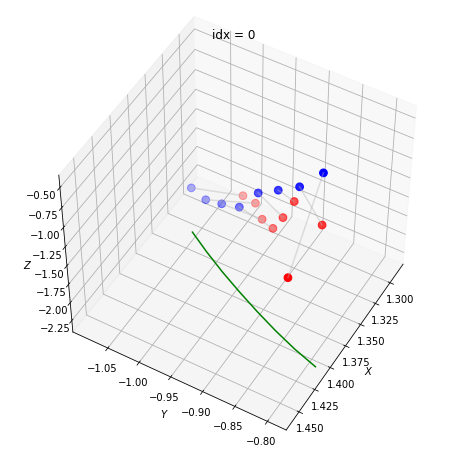

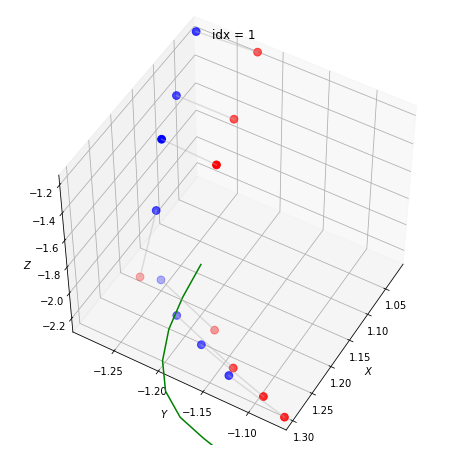

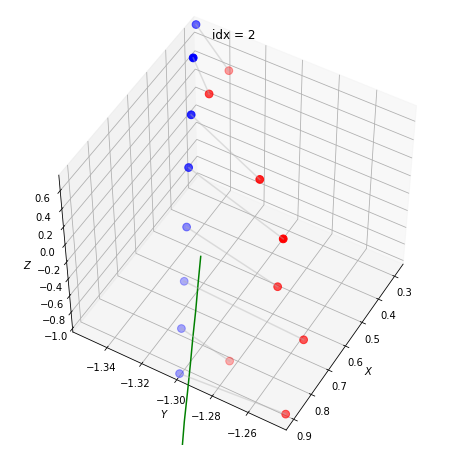

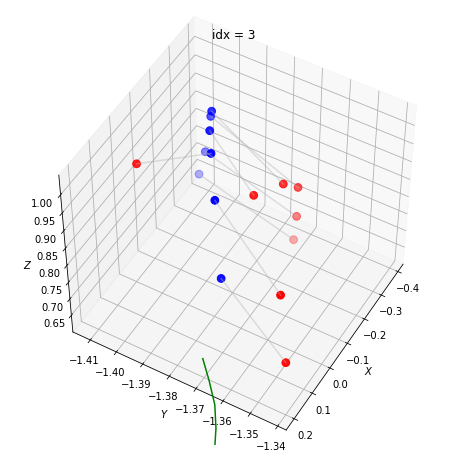

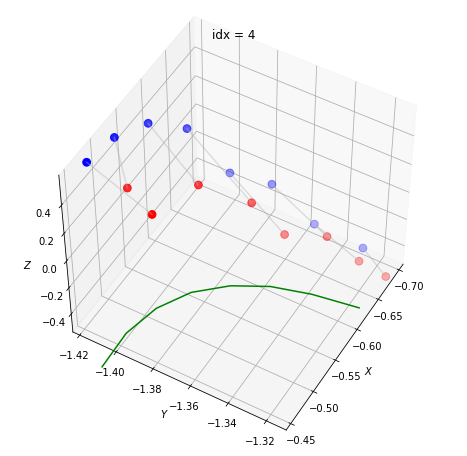

In [73]:
# Test model
# tb_images, tb_poses = next(iter(test_dataloader))
# print('tb_poses = {}'.format(tb_poses))


def set_3d_axes_limits(ax, poses, pose_format='quat'):
    p_min, p_max, p_mean, p_std = calc_poses_params(poses, pose_format=pose_format)
    ax.set_xlim(p_min[0], p_max[0])
    ax.set_ylim(p_min[1], p_max[1])
    ax.set_zlim(p_min[2], p_max[2])
    return p_min, p_max, p_mean, p_std


def draw_pred_gt_poses(pred_poses, gt_poses):
    fig = plt.figure(figsize=(8, 8))
    ax = plt.axes(projection='3d')

    ax.set_xlabel('$X$')
    ax.set_ylabel('$Y$')
    ax.set_zlabel('$Z$')
    ax.view_init(50, 30)

    all_poses = np.concatenate((pred_poses, gt_poses))
    p_min, _, _, _ = set_3d_axes_limits(ax, all_poses, pose_format='quat')
    
    draw_poses(ax, pred_poses[:, :3], proj=False, proj_z=int(p_min[2] - 1), c='r', s=60)
    draw_poses(ax, gt_poses[:, :3], proj=True, proj_z=int(p_min[2] - 1), c='b', s=60)
    for i in range(pred_poses.shape[0]):
        pp = pred_poses[i, :3]
        gp = gt_poses[i, :3]
        pps = np.vstack((pp, gp))
        ax.plot(pps[:, 0], pps[:, 1], pps[:, 2], c=(0.7, 0.7, 0.7, 0.4))
        
    plt.draw()


    

# train_dataloader = DataLoader(train_dataset, batch_size=16)

# p_min, p_max, p_mean, p_std = train_dataset.get_poses_params(all_records=False)


# fig = plt.figure(figsize=(8, 8))
# ax = plt.axes(projection='3d')

# ax.set_xlabel('$X$')
# ax.set_ylabel('$Y$')
# ax.set_zlabel('$Z$')
# ax.view_init(50, 30)


# ax.set_xlim(int(p_min[0] - 1), int(p_max[0] + 1))
# ax.set_ylim(int(p_min[1] - 1), int(p_max[1] + 1))
# ax.set_zlim(int(p_min[2] - 1), int(p_max[2] + 1))

model.train()

for idx, (tb_images, tb_poses) in enumerate(train_dataloader):
    tb_images = [x.to(device) for x in tb_images]
    output = model(tb_images)
#     print('output = {}'.format(output))

    # detach
    output = [x.cpu().detach().numpy() for x in output]
    
    draw_pred_gt_poses(output[0], tb_poses[0])
    plt.title('idx = {}'.format(idx))
    plt.show()
    
    # gt + pred poses
#     all_poses = np.concatenate((output[0][:, :3], tb_poses[0][:, :3]))
#     set_3d_axes_limits(ax, all_poses, pose_format=train_dataset.pose_format)
    
#     draw_poses(ax, output[0][:, :3], proj=False, proj_z=int(p_min[2] - 1), c='r', s=60)
#     draw_poses(ax, tb_poses[0][:, :3], proj=True, proj_z=int(p_min[2] - 1), c='b', s=60)
#     for i in range(output[0].shape[0]):
#         pp = output[0][i, :3]
#         gp = tb_poses[0][i, :3]
#         pps = np.vstack((pp, gp))
#         ax.plot(pps[:, 0], pps[:, 1], pps[:, 2], c=(0.7, 0.7, 0.7, 0.4))
    
    if idx == 4:
        break
        
#     plt.draw()
    
    
#     ax.scatter(tb_poses[0][:, 0], tb_poses[0][:, 1], tb_poses[0][:, 2], c='r')

plt.show()

## Save Model Checkpoint

In [74]:
# Save checkpoint
save_checkpoint(model, optimizer, 'apollo_zpark_r001_v2', n_epochs)
    

'_checkpoints/20180802_192657_apollo_zpark_r001_v2_e3400.pth.tar'